# Serial autocorrelation

In [16]:
library(here)
library(haven)
library(sdazar)
library(ggplot2)
library(brms)
options(mc.cores = parallel::detectCores()-2)
library(imputeTS)
# library(stringr)
# library(ggridges)
# library(patchwork)
options(repr.plot.width = 5, repr.plot.height = 3)

In [4]:
# load data
df = data.table(read_stata('../data/Ex_LA1850-2013_SES_ABBREVIATED_april-3-2018.dta'))

country_labels = c("Argentina", "Bolivia", "Brazil", "Chile", "Colombia", 
                   "Costa_Rica", "Cuba", "Dominican_Republic", "Ecuador", 
                   "El_Salvador", "Guatemala", "Honduras", "Mexico", "Nicaragua", 
                   "Panama", "Paraguay", "Peru", "Uruguay", "Venezuela")

df[, ctry := factor(ctry, labels=country_labels)]

# Only male-female average and records since 1900

In [6]:
covariates = names(df)[10:28]

c = df[tseries2==1 & age==0 & year>=1900, lapply(.SD,Max), 
       .SDcols=covariates, by=.(ctry, year)]

le = df[tseries2==1 & age==0 & year>=1900, .(Ex=Mean(Ex)), by=.(ctry, year)]

# check
# (nrow(c) + nrow(le))/2

dt = merge(c, le, by=c('ctry', 'year'))

# missing data
print(countmis(dt))

       bf      elec       lsi       lit   extFund      gini     water    sewage 
    0.977     0.951     0.922     0.852     0.844     0.820     0.775     0.773 
healthGdp     polio       bcg      dpt1      dpt3      mcv1     urban       tfr 
    0.709     0.681     0.681     0.681     0.681     0.681     0.451     0.445 
   us_aid    gdp_pc 
    0.360     0.103 


In [17]:
# patterns 
ggplot_missing <- function(x){
  
    data = data.table(melt(is.na(x)))
    vars = names(countmis(x, exclude.complete=FALSE))
    data[, Var2 := factor(Var2, levels=vars)]
    
    ggplot(data,
           aes(x = Var2,
               y = Var1)) +
    geom_raster(aes(fill = value)) +
    scale_fill_grey(name = "",
                    labels = c("Present","Missing")) +
    theme_minimal() + 
    theme(axis.text.x  = element_text(angle=45, vjust=0.5)) + 
    labs(x = "Variables in Dataset",
         y = "Rows / observations")
}

# Exploring imputations (MI)

### Setting the dataset

In [18]:
test = dt[year>=1900, .(ctry, year, gdp_pc, urban, lit, Ex, water, sewage, elec, us_aid, tfr)]

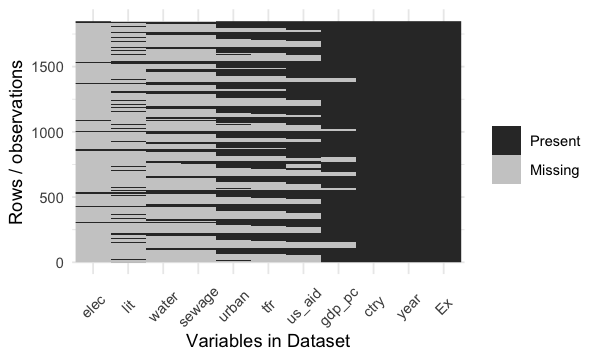

In [19]:
ggplot_missing(test)

In [20]:
# year recode based on the criteria proposed by Alberto
test[year<1950, gyear:='1950']
test[year>=1950 & year<1970, gyear:='1950-1969']
test[year>=1970 & year<1990, gyear:='1970-1989']
test[year>=1990, gyear :='1990']
# # test[, gyear := factor(gyear, levels=1:4, labels=c('1950', '1950-1969', '1970-1989', '1990'))]

# transform variable: weibull
test[, y := Ex/max(Ex+1.05), by = ctry] # adjustment is by country!
test[, wy := log(-log(1-y))]
max_le = test[, .(max_le = max(Ex+1.05)), by = ctry] # to recover values later
test[, ctry_year := paste0(ctry,'.', gyear)]

In [21]:
head(test)

ctry,year,gdp_pc,urban,lit,Ex,water,sewage,elec,us_aid,tfr,gyear,y,wy,ctry_year
Argentina,1900,2875.352,NA,51,36.25867,NA,NA,NA,NA,NA,1950,0.4762391,-0.4358419,Argentina.1950
Argentina,1901,2880.387,NA,NA,36.63120,NA,NA,NA,NA,NA,1950,0.4811320,-0.4214333,Argentina.1950
Argentina,1902,2716.507,NA,NA,37.00985,NA,NA,NA,NA,NA,1950,0.4861054,-0.4068604,Argentina.1950
Argentina,1903,2992.315,NA,NA,37.39479,NA,NA,NA,NA,NA,1950,0.4911614,-0.3921179,Argentina.1950
Argentina,1904,3191.040,NA,NA,37.82295,NA,NA,NA,NA,NA,1950,0.4967851,-0.3758025,Argentina.1950
Argentina,1905,3478.617,NA,NA,38.48985,NA,NA,NA,NA,NA,1950,0.5055445,-0.3505536,Argentina.1950


In [22]:
# number of countries
length(unique(test$ctry))

[1] 19

# 1900+ model using gdp, lit, urban imputed (Interpolation)

In [23]:
library(imputeTS)

test = data.table(test)
setorder(test, year)

# interpolation
test[, igdp_pc := na.interpolation(gdp_pc, option='stine'), by=ctry]
test[, iurban := na.interpolation(urban, option='stine'), by=ctry]
test[, ilit := na.interpolation(lit, option='stine'), by=ctry]
test[, itfr := na.interpolation(tfr, option='stine'), by=ctry]

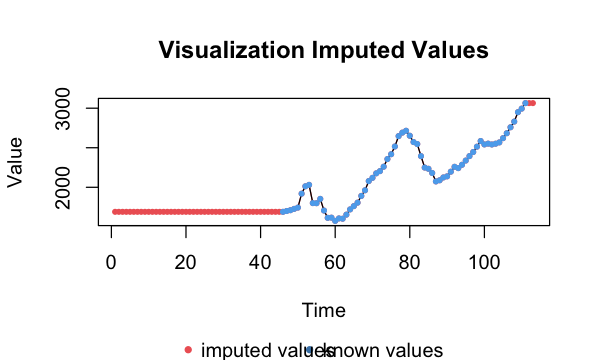

In [24]:
country = 'Bolivia'
variable = 'gdp_pc'
imp = paste0('i', variable)

plotNA.imputations(test[ctry==country, variable, with=FALSE][[1]], 
                   test[ctry==country, imp, with=FALSE][[1]])

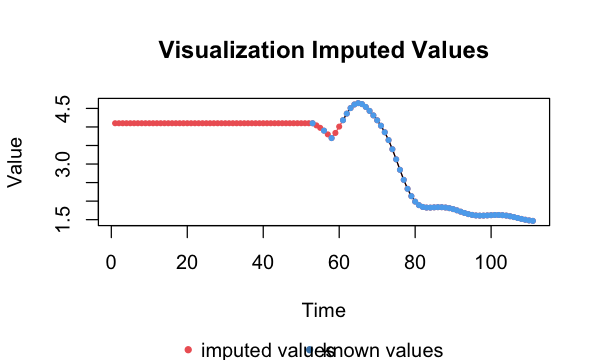

In [25]:
country = 'Cuba'
variable = 'tfr'
imp = paste0('i', variable)

plotNA.imputations(test[ctry==country, variable, with=FALSE][[1]], 
                   test[ctry==country, imp, with=FALSE][[1]])

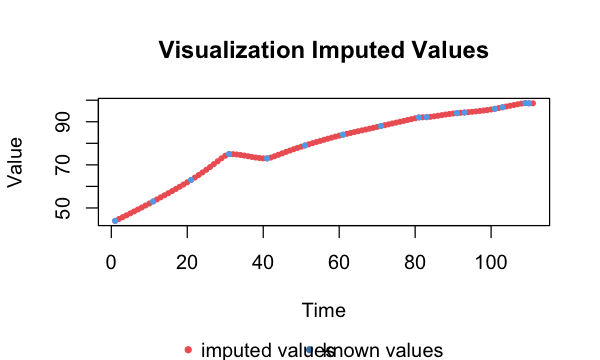

In [26]:
country = 'Chile'
variable = 'lit'
imp = paste0('i', variable)

plotNA.imputations(test[ctry==country, variable, with=FALSE][[1]], 
                   test[ctry==country, imp, with=FALSE][[1]])

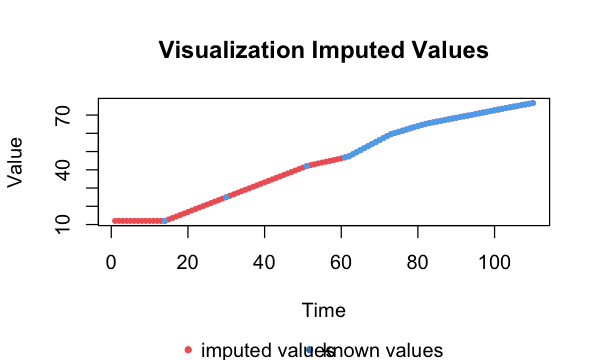

In [27]:
country = 'Peru'
variable = 'urban'
imp = paste0('i', variable)

plotNA.imputations(test[ctry==country, variable, with=FALSE][[1]], 
                   test[ctry==country, imp, with=FALSE][[1]])

## Bayesian models using the interpolation method

In [28]:
test[, igdp_log := scale(log(igdp_pc), scale=FALSE, center=TRUE)]
test[, iurban_log := scale(log(iurban), scale=FALSE, center=TRUE)]
test[, ilit_log := scale(log(ilit), scale=FALSE, center=TRUE)]

In [29]:
# lag variables and fitering
setorder(test, ctry, year)

In [30]:
test[, lag_igdp_log := shift(igdp_log), by=ctry]
test[, lag_iurban_log := shift(iurban_log), by=ctry]
test[, lag_ilit_log := shift(ilit_log), by=ctry]
test[, year_c := scale(year, center=TRUE, scale=FALSE)]

# Models 

In [ ]:
m2.1 = brm(formula = wy ~ 1 + igdp_log  + (igdp_log|ctry_year), 
           data = test,
           iter = 2000, 
           chains = 2,
           prior = c(set_prior("normal(0,2)", class = "b")))

Compiling the C++ model
Start sampling


In [19]:
# impute using Amelia (30 imputations, it should be more!)
idvars = c('y', 'wy', 'gyear', 'ctry_year')

In [20]:
# define bounds
vars = c('urban', 'lit', 'water', 'sewage', 'elec')
i = which(names(test) %in% vars)
bounds = cbind(i, rep(0, length(i)), rep(100, length(i)))

In [19]:
test = as.data.frame(test) # remember to use only dataframes

# Multiple imputation (Amelia) 
## Only five imputations for testing

In [63]:
library(Amelia)
library(parallel)
library(miceadds)

out1 = amelia(x=test, 
              idvars = idvars, 
              bounds = bounds, 
              m=5, # only five!
              ts = 'year', cs = 'ctry', 
              splinetime = 4, intercs = TRUE,  
              p2s = 0, logs=c('gdp_pc', 'Ex', 'us_aid', 'water', 'sewage', 'elec'), 
              lags = c('gdp_pc', 'Ex', 'urban', 'tfr'), 
              leads = c('Ex', 'gdp_pc', 'urban', 'tfr'),
              empri = .01*nrow(test), 
              parallel='multicore', ncpus=3)

I included some regularization via the Ridge term (`empri`). 

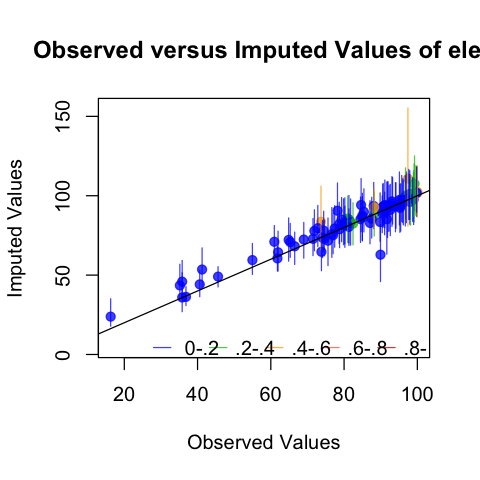

In [64]:
# over-imputation assessment (see King's paper for details)
options(repr.plot.width = 4, repr.plot.height = 4)
overimpute(out1, var = 'elec')

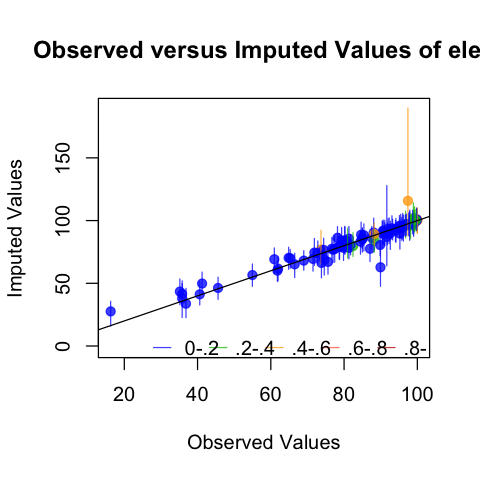

In [52]:
options(repr.plot.width = 4, repr.plot.height = 4)
overimpute(out1, var = 'water')

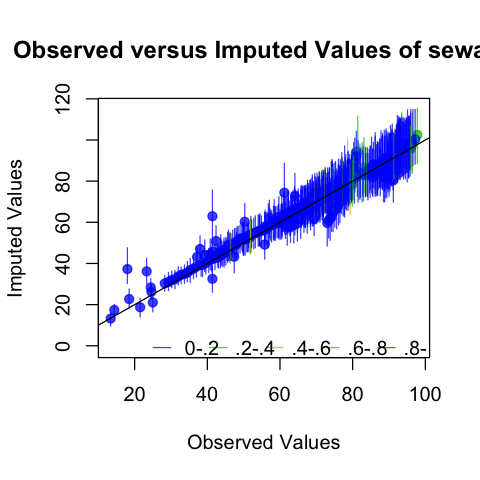

In [65]:
options(repr.plot.width = 4, repr.plot.height = 4)
overimpute(out1, var = 'sewage')

### Some examples by country (imputations)

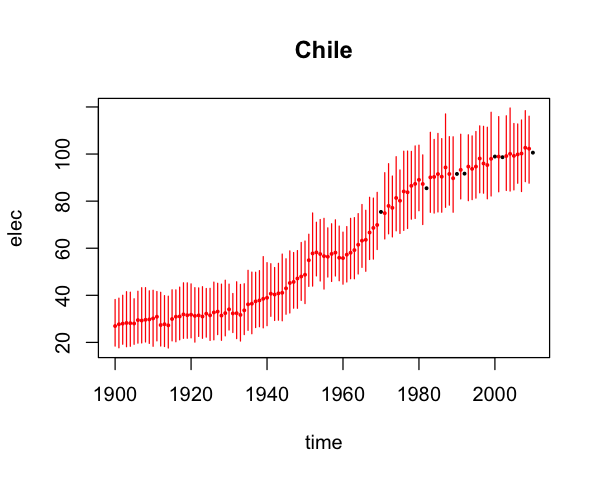

In [66]:
options(repr.plot.width = 5, repr.plot.height = 4)
tscsPlot(out1, cs = 'Chile', var = 'elec', cex = 0.3)

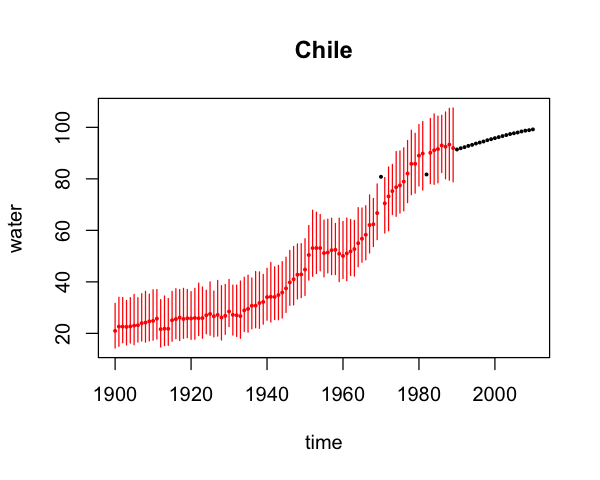

In [67]:
options(repr.plot.width = 5, repr.plot.height = 4)
tscsPlot(out1, cs = 'Chile', var = 'water', cex = 0.3)

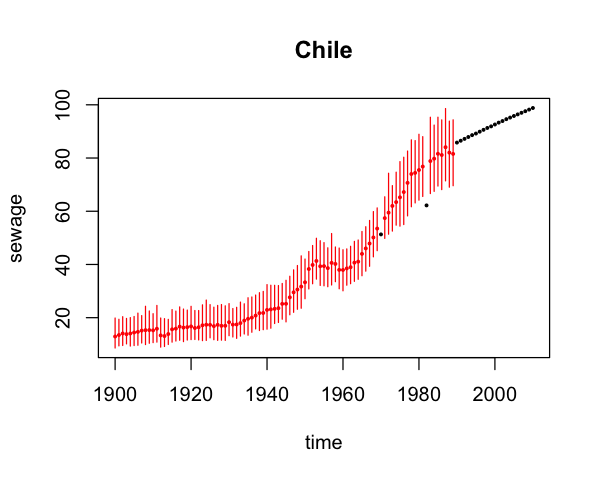

In [68]:
options(repr.plot.width = 5, repr.plot.height = 4)
tscsPlot(out1, cs = 'Chile', var = 'sewage', cex = 0.3)

# 1900+ model using gdp, lit, urban imputed (MI)

In [ ]:
# transformations before bayesian model  (log and center)
out1 = transform(out1, gdp_log = as.vector(scale(log(gdp_pc), scale=FALSE, center=TRUE)))
out1 = transform(out1, lit_log = as.vector(scale(log(lit+0.01), scale=FALSE, center=TRUE)))
out1 = transform(out1, urban_log = as.vector(scale(log(urban+0.01), scale=FALSE, center=TRUE)))

imputations = datalist2mids(out1$imputations)

## Bayesian model using MI (pretty slow!)

This is slow, let's see how faster it runs in Linstat.

In [71]:
m1 = brm_multiple(formula = wy ~ 1 + gdp_log + lit_log + urban_log + (gdp_log|ctry_year), 
                  data = imputations, 
                  chains=2, iter=2000)

Fitting imputed model 1
Compiling the C++ model
Start sampling
Fitting imputed model 2
Start sampling
Fitting imputed model 3
Start sampling
Fitting imputed model 4
Start sampling
Fitting imputed model 5
Start sampling


In [72]:
# compare this model with the model m2.4 below
summary(m1) # skip message on not converged

Warning message:
“The model has not converged (some Rhats are > 1.1). Do not analyse the results! 
We recommend running more iterations and/or setting stronger priors.”

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: wy ~ 1 + gdp_log + lit_log + urban_log + (gdp_log | ctry_year) 
   Data: imputations (Number of observations: 1848) 
Samples: 10 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 10000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Group-Level Effects: 
~ctry_year (Number of levels: 74) 
                       Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)              0.46      0.04     0.38     0.55        608 1.02
sd(gdp_log)                0.59      0.07     0.47     0.72         17 1.18
cor(Intercept,gdp_log)    -0.06      0.13    -0.32     0.20        154 1.04

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
Intercept     0.26      0.06     0.15     0.37        657 1.01
gdp_log       0.56      0.08     0.40     0.72         39 1.07
lit_log       0.19      0.02     0.14     0.24         12 1.29
urban_log     0.15  

In [77]:
# convergence looks fine!
round(m1$rhats, 2)

b_Intercept,b_gdp_log,b_lit_log,b_urban_log,sd_ctry_year__Intercept,sd_ctry_year__gdp_log,cor_ctry_year__Intercept__gdp_log,sigma,r_ctry_year.Argentina.1950.Intercept.,r_ctry_year.Argentina.1950.1969.Intercept.,⋯,r_ctry_year.Peru.1990.gdp_log.,r_ctry_year.Uruguay.1950.gdp_log.,r_ctry_year.Uruguay.1950.1969.gdp_log.,r_ctry_year.Uruguay.1970.1989.gdp_log.,r_ctry_year.Uruguay.1990.gdp_log.,r_ctry_year.Venezuela.1950.gdp_log.,r_ctry_year.Venezuela.1950.1969.gdp_log.,r_ctry_year.Venezuela.1970.1989.gdp_log.,r_ctry_year.Venezuela.1990.gdp_log.,lp__
1.02,1.01,1,1,1.01,1.00,1.01,1,1.01,1,⋯,1,1.00,1,1,1,1.00,1,1,1,1.00
1.01,1.01,1,1,1.00,1.01,1.00,1,1.01,1,⋯,1,1.00,1,1,1,1.00,1,1,1,1.00
1.01,1.01,1,1,1.00,1.00,1.01,1,1.01,1,⋯,1,1.01,1,1,1,1.01,1,1,1,1.00
1.00,1.00,1,1,1.01,1.00,1.01,1,1.00,1,⋯,1,1.00,1,1,1,1.00,1,1,1,1.01
1.00,1.00,1,1,1.00,1.00,1.00,1,1.00,1,⋯,1,1.00,1,1,1,1.00,1,1,1,1.00


In [36]:
summary(m2.1)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: wy ~ 1 + igdp_log + (igdp_log | ctry_year) 
   Data: test (Number of observations: 1848) 
Samples: 2 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 2000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Group-Level Effects: 
~ctry_year (Number of levels: 74) 
                        Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)               0.54      0.05     0.45     0.64        351 1.00
sd(igdp_log)                0.67      0.07     0.55     0.81        569 1.00
cor(Intercept,igdp_log)     0.07      0.13    -0.19     0.32        408 1.00

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
Intercept     0.34      0.07     0.22     0.47        236 1.01
igdp_log      0.76      0.08     0.60     0.92        545 1.00

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sigma     0.11     

In [ ]:
m2.1a = brm(formula = wy ~ 1 + igdp_log  + (igdp_log|ctry_year), 
           autocor = cor_ar(~ 1|ctry_year, p=1, cov=TRUE),
           data = test,
           iter = 2000, 
           chains = 2,
           prior = c(set_prior('normal(0,1)', class = 'ar'),
                             set_prior('normal(0,5)', class = 'b')))

Compiling the C++ model
Start sampling


In [ ]:
summary(m2.1a)

In [55]:
resid = resid(m2.1, type = 'pearson')[, "Estimate"]
fit = predict(m2.1)[, 'Estimate']

ggplot(data = NULL, aes(y = resid, x = fit)) +
    geom_point(size=0.2, alpha=0.8, color='gray') + stat_smooth(geom='line', color='red') + 
    theme_classic()

In [56]:
library(forecast)

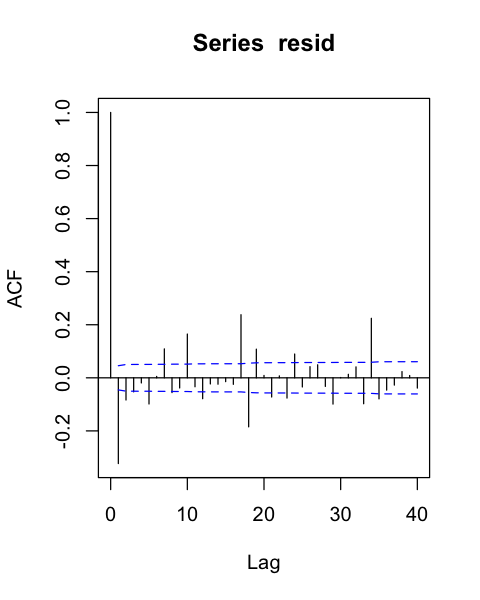

In [57]:
options(repr.plot.width = 4, repr.plot.height = 5)
acf(resid, lag = 40, ci.type = 'ma')

In [263]:
plot_resid_brms = function(model, y, nlines=500, alpha=0.02, size=0.2) { 

        res = residuals(model, summary=FALSE, type='pearson')
        d = data.table(t(res), y)
        m = melt(d, id.vars='y')
        m[, group := .GRP, by=variable]
        p = ggplot(m[group %in% 1:nlines], aes(y, value, group=group)) +
               stat_smooth(geom='line', alpha=alpha, size=size, se=FALSE, color='red') + 
               theme_classic() + 
                ylab('pearson residuals') + 
                xlab('y (weibull transformation)')
        return(p)
}

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


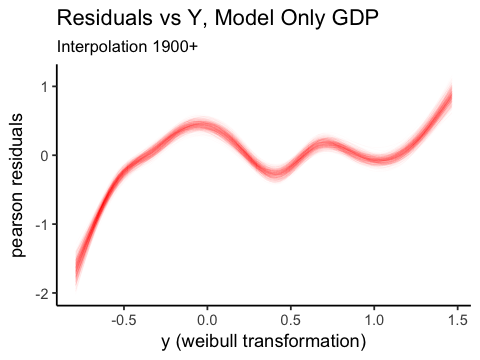

In [264]:
options(repr.plot.width = 4, repr.plot.height = 3)
plot_resid_brms(m2.1, y=test[,wy]) +
labs(title='Residuals vs Y, Model Only GDP + AR', subtitle='Interpolation 1900+')

In [29]:
options(repr.plot.width = 4, repr.plot.height = 3)
plot_resid_brms(m2.1, y=test[,wy]) +
labs(title='Residuals vs Y, Model Only GDP', subtitle='Interpolation 1900+')

In [29]:
loo2.1 = loo(m2.1, reloo=TRUE)

No problematic observations found. Returning the original 'loo' object.


In [32]:
# summary(m2.1)

In [260]:
m2.2 = brm(formula = wy ~ 1 + igdp_log  + iurban_log +  (igdp_log|ctry_year), 
                  data = test)

Compiling the C++ model


In [34]:
loo2.2 = loo(m2.2, reloo=TRUE)

1 problematic observation(s) found.
The model will be refit 1 times.

Fitting model 1 out of 1 (leaving out observation 651)
Start sampling


In [36]:
m2.3 = brm(formula = wy ~ 1 + igdp_log  + ilit_log +  (igdp_log|ctry_year), 
                  data = test)

Compiling the C++ model
Start sampling


In [37]:
loo2.3 = loo(m2.3, reloo=TRUE)

1 problematic observation(s) found.
The model will be refit 1 times.

Fitting model 1 out of 1 (leaving out observation 1446)
Start sampling


In [258]:
m2.4 = brm(formula = wy ~ 1 + igdp_log + ilit_log + iurban_log + (igdp_log|ctry_year), 
                  data = test)

Compiling the C++ model
Start sampling


`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


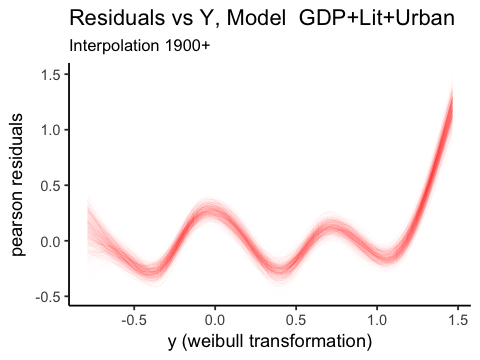

In [259]:
options(repr.plot.width = 4, repr.plot.height = 3)
plot_resid_brms(m2.4, y=test[,wy]) +
labs(title='Residuals vs Y, Model  GDP+Lit+Urban', subtitle='Interpolation 1900+')

In [39]:
loo2.4 = loo(m2.4, reloo=TRUE)

No problematic observations found. Returning the original 'loo' object.


In [40]:
# stacking
loo_list = list(loo2.1, loo2.2, loo2.3, loo2.4)
loo_model_weights(loo_list)

Method: stacking
------
       weight
model1 0.014 
model2 0.000 
model3 0.017 
model4 0.969 

In [78]:
# compare this model with m1 (above) using multiple imputation
summary(m2.4)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: wy ~ 1 + igdp_log + ilit_log + iurban_log + (igdp_log | ctry_year) 
   Data: test (Number of observations: 1848) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 4000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Group-Level Effects: 
~ctry_year (Number of levels: 74) 
                        Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)               0.41      0.04     0.34     0.49        740 1.00
sd(igdp_log)                0.61      0.06     0.51     0.73       1343 1.00
cor(Intercept,igdp_log)     0.06      0.13    -0.19     0.31        791 1.00

Population-Level Effects: 
           Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
Intercept      0.22      0.05     0.12     0.32        390 1.01
igdp_log       0.40      0.07     0.26     0.54        776 1.00
ilit_log       0.56      0.03     0.49     0.62       4000 1.00
iurban_log     0.

# Imputation 1950+ of elec, sewage, water using interpolated urban, gdp and lit

In [113]:
test = data.table(test)
test50 = test[year>=1950]

In [114]:
test50 = data.frame(test50)

In [115]:
nrow(test50)

[1] 1160

In [117]:
# impute using Amelia (30 imputations, it should be more!)
idvars = c('y', 'wy', 'gyear', 'ctry_year', 'gdp_pc', 'tfr', 'urban', 'lit')

In [120]:
# define bounds
vars = c('water', 'sewage', 'elec')
i = which(names(test50) %in% vars)
bounds = cbind(i, rep(0, length(i)), rep(100, length(i)))

## Multiple imputation (Amelia) 

In [132]:
library(Amelia)
library(parallel)
library(miceadds)

out2 = amelia(x=test50, 
              idvars = idvars, 
              bounds = bounds, 
              m=5, # only five!
              ts = 'year', cs = 'ctry', 
              splinetime = 5, intercs = TRUE,  
              p2s = 0, logs=c('igdp_pc', 'iurban', 'ilit', 'Ex', 'itfr', 
                              'us_aid', 'water', 'sewage', 'elec'), 
              lags = c('igdp_pc', 'Ex', 'iurban', 'itfr', 'water', 'sewage', 'elec'), 
              leads = c('Ex', 'igdp_pc', 'iurban', 'itfr', 'water', 'sewage', 'elec'),
              empri = .01*nrow(test), 
              parallel='multicore', ncpus=3)

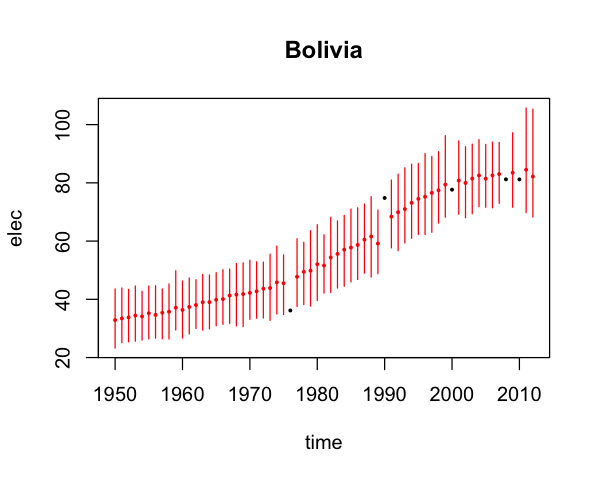

In [134]:
options(repr.plot.width = 5, repr.plot.height = 4)
tscsPlot(out2, cs = 'Bolivia', var = 'elec', cex = 0.3)

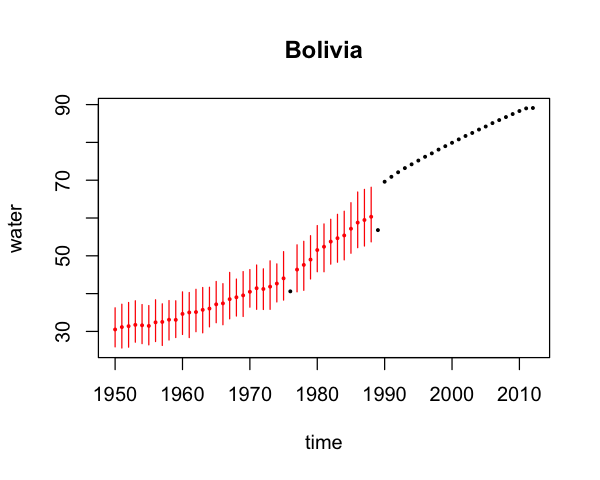

In [136]:
options(repr.plot.width = 5, repr.plot.height = 4)
tscsPlot(out2, cs = 'Bolivia', var = 'water', cex = 0.3)

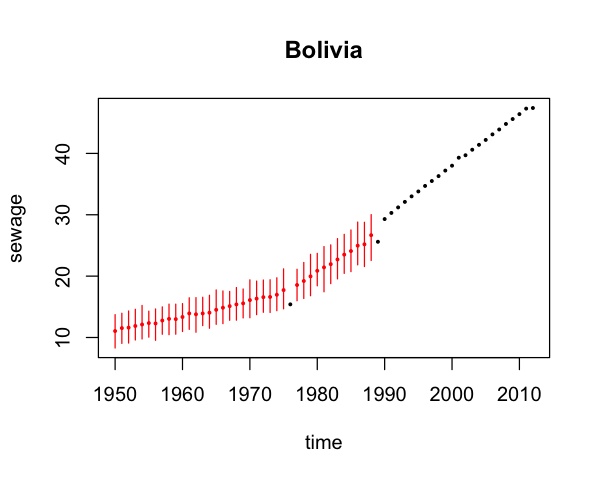

In [137]:
options(repr.plot.width = 5, repr.plot.height = 4)
tscsPlot(out2, cs = 'Bolivia', var = 'sewage', cex = 0.3)

In [138]:
# transformations before bayesian model  (log and center)
out2 = transform(out2, igdp_log = as.vector(scale(log(igdp_pc), scale=FALSE, center=TRUE)))
out2 = transform(out2, ilit_log = as.vector(scale(log(ilit), scale=FALSE, center=TRUE)))
out2 = transform(out2, iurban_log = as.vector(scale(log(iurban), scale=FALSE, center=TRUE)))

out2 = transform(out2, elec_log = as.vector(scale(log(elec+0.01), scale=FALSE, center=TRUE)))
out2 = transform(out2, water_log = as.vector(scale(log(water+0.01), scale=FALSE, center=TRUE)))
out2 = transform(out2, sewage_log = as.vector(scale(log(sewage+0.01), scale=FALSE, center=TRUE)))

imputations = datalist2mids(out2$imputations)

Warning message in data.matrix(x):
“NAs introduced by coercion”Warning message in data.matrix(x):
“NAs introduced by coercion”Warning message in data.matrix(x):
“NAs introduced by coercion”Warning message in data.matrix(x):
“NAs introduced by coercion”

In [139]:
m3 = brm_multiple(formula = wy ~ 1 + igdp_log + ilit_log + iurban_log + 
                  elec_log + water_log + sewage_log + (igdp_log|ctry_year), 
                  data = imputations)

Fitting imputed model 1
Compiling the C++ model
Start sampling
Fitting imputed model 2
Start sampling
Fitting imputed model 3
Start sampling
Fitting imputed model 4
Start sampling
Fitting imputed model 5
Start sampling


In [140]:
summary(m3)

Warning message:
“The model has not converged (some Rhats are > 1.1). Do not analyse the results! 
We recommend running more iterations and/or setting stronger priors.”

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: wy ~ 1 + igdp_log + ilit_log + iurban_log + elec_log + water_log + sewage_log + (igdp_log | ctry_year) 
   Data: imputations (Number of observations: 1160) 
Samples: 20 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 20000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Group-Level Effects: 
~ctry_year (Number of levels: 57) 
                        Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)               0.40      0.04     0.32     0.49       2084 1.01
sd(igdp_log)                0.59      0.06     0.48     0.72       3883 1.01
cor(Intercept,igdp_log)     0.09      0.14    -0.19     0.36       2697 1.01

Population-Level Effects: 
           Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
Intercept      0.61      0.05     0.51     0.72       1937 1.01
igdp_log       0.28      0.08     0.12     0.44       3041 1.01
ilit_log       0.55      0.07     0.

In [ ]:
log_lik3 = log_lik(m3)

In [ ]:
loo3 = loo(m3, reloo=TRUE)

In [99]:
round(m3$rhats, 2)

b_Intercept,b_igdp_log,b_ilit_log,b_iurban_log,b_elec_log,b_water_log,b_sewage_log,sd_ctry_year__Intercept,sd_ctry_year__igdp_log,cor_ctry_year__Intercept__igdp_log,⋯,r_ctry_year.Peru.1990.igdp_log.,r_ctry_year.Uruguay.1950.igdp_log.,r_ctry_year.Uruguay.1950.1969.igdp_log.,r_ctry_year.Uruguay.1970.1989.igdp_log.,r_ctry_year.Uruguay.1990.igdp_log.,r_ctry_year.Venezuela.1950.igdp_log.,r_ctry_year.Venezuela.1950.1969.igdp_log.,r_ctry_year.Venezuela.1970.1989.igdp_log.,r_ctry_year.Venezuela.1990.igdp_log.,lp__
1.01,1.00,1,1,1,1,1,1.00,1,1.00,⋯,1,1,1,1,1,1,1,1,1,1.01
1.01,1.00,1,1,1,1,1,1.00,1,1.01,⋯,1,1,1,1,1,1,1,1,1,1.00
1.00,1.00,1,1,1,1,1,1.01,1,1.00,⋯,1,1,1,1,1,1,1,1,1,1.01
1.01,1.00,1,1,1,1,1,1.00,1,1.01,⋯,1,1,1,1,1,1,1,1,1,1.00
1.02,1.01,1,1,1,1,1,1.01,1,1.00,⋯,1,1,1,1,1,1,1,1,1,1.00
